## Run SCARP to get cell and peak embedding of SOX10 knockdown data

In [1]:
import sys
sys.path.append('../Scarp/')

from downstream import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(1)
random_state = 1
beta = 5000
m = 1.5
merge_thre = 3000

In [3]:
data = sc.read_h5ad('../Exp1_Benchmark/Processed data/Sox10KD.h5ad')
sc.pp.filter_genes(data, min_cells=1)

In [4]:
Cells = data.obs.index
Peaks = data.var.index
Cells_num, Peaks_num = data.X.shape
N = Cells_num + Peaks_num
labels = data.obs['celltype'].astype('category')
cluster_num = np.unique(labels).shape[0]
print('Number of Peaks:', Peaks_num)
print('Number of Cells:', Cells_num)
print('Number of labels: ', cluster_num)

Number of Peaks: 78659
Number of Cells: 598
Number of labels:  8


In [5]:
t, diffusion_mat = SCARP(data=data,
                         m=m,
                         merge_thre=merge_thre,
                         beta=beta,
                         peak_loc=True)


%%%%%%%%%%%%%%%%%%%%%%% Diffusion Started (with 23 cores parallel computing)%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Finished %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Running time: 142.89636707305908s

Matrix Splicing...........
Splicing time: 2.8856821060180664s


In [6]:
data_name = 'Sox10KD'
k = std_plot(data=diffusion_mat,
             title=data_name,
             max_k=100,
             plot_std=True,
             save_file='./results/Kept component of ' + data_name + '.svg')

In [7]:
cell_embedding = SCARP_cell_embedding(diffusion_mat=diffusion_mat,
                                      kept_comp=k)

Cells_df = pd.DataFrame(cell_embedding,
                        index=Cells,
                        columns=['feature' + str(i + 1) for i in range(cell_embedding.shape[1])])
Cells_df.to_csv('./Results/SOX10_SCARP_Cells_feature.csv')

In [8]:
adata_cell = sc.AnnData(Cells_df)
adata_cell.var_names_make_unique()
adata_cell.obs['label'] = labels

In [9]:
sc.pp.neighbors(adata_cell, use_rep='X', random_state=random_state)
sc.tl.umap(adata_cell, random_state=random_state)

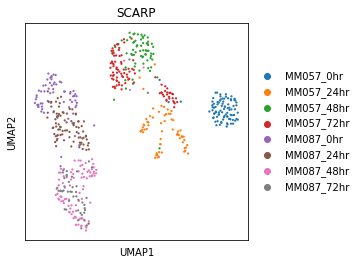

<Figure size 432x288 with 0 Axes>

In [10]:
fig1, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata_cell, color='label', title='SCARP', s=20, ax=ax)
plt.subplots_adjust(right=0.55)

In [11]:
peaks_embedding = SCARP_cell_embedding(diffusion_mat[:, Cells_num:].T, k)
Peaks_df = pd.DataFrame(peaks_embedding,
                        index=Peaks,
                        columns=['feature' + str(i + 1) for i in range(peaks_embedding.shape[1])])
Peaks_df.to_csv('./Results/SOX10_SCARP_Peaks_feature.csv')

## Saving peaks.bed file 

In [12]:
Peaks = Peaks.to_list()
Peaks_bed = pd.DataFrame([re.split('_|\W+', i) for i in Peaks])
Peaks_bed.to_csv('./Processed data/Sox10KD_peaks.bed', header=None, sep='\t', index=None)